<a href="https://colab.research.google.com/github/Adefolarin-o/chest-xray-pneumonia-detection-ssl/blob/main/Chest_XRay_Pneumonia_Detection_SSL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# --- CELL 1: Install required packages and import libraries ---
%%capture
!pip install torch torchvision timm kagglehub scikit-learn matplotlib

import os
import shutil
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import kagglehub
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

In [3]:
# --- CELL 2: Mount Google Drive and set seeds for reproducibility ---
# Mount Google Drive for saving models and results
drive.mount('/content/drive')
save_dir = Path('/content/drive/MyDrive/pneumonia_detection')
save_dir.mkdir(exist_ok=True, parents=True)

# Set seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Mounted at /content/drive
Using device: cuda


In [4]:
# --- CELL 3: Download and explore the dataset ---
# Download dataset from Kaggle
dataset_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
chest_xray_path = os.path.join(dataset_path, 'chest_xray')

# Verify dataset structure
print(f"Dataset path: {dataset_path}")
print(f"Contents: {os.listdir(dataset_path)}")

# Display dataset structure and counts
print("\n--- Dataset Structure ---")
for folder in ["train", "val", "test"]:
    folder_path = os.path.join(chest_xray_path, folder)
    print(f"\n📁 {folder}: {os.listdir(folder_path)}")  # List classes (PNEUMONIA, NORMAL)

# Count images in each folder and class
for folder in ["train", "val", "test"]:
    for class_name in ["PNEUMONIA", "NORMAL"]:
        class_path = os.path.join(chest_xray_path, folder, class_name)
        num_images = len(os.listdir(class_path))
        print(f"{folder}/{class_name}: {num_images} images")

100%|██████████| 2.29G/2.29G [00:24<00:00, 100MB/s]


Dataset path: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2
Contents: ['chest_xray']

--- Dataset Structure ---

📁 train: ['NORMAL', 'PNEUMONIA']

📁 val: ['NORMAL', 'PNEUMONIA']

📁 test: ['NORMAL', 'PNEUMONIA']
train/PNEUMONIA: 3875 images
train/NORMAL: 1341 images
val/PNEUMONIA: 8 images
val/NORMAL: 8 images
test/PNEUMONIA: 390 images
test/NORMAL: 234 images


In [5]:
# --- CELL 4: Create SSL dataset structure ---
# Create directories for SSL training
ssl_dir = Path("./chest_xray_ssl")
ssl_dir.mkdir(exist_ok=True)

# Create subdirectories for SSL approach
(ssl_dir / "train_ssl").mkdir(exist_ok=True)  # Normal images for SSL pretraining
(ssl_dir / "val_ssl").mkdir(exist_ok=True)    # Split from train's normal images
(ssl_dir / "test").mkdir(exist_ok=True)       # Original test set with both classes

# Copy and split normal images for SSL training
original_normal_train = Path(chest_xray_path) / "train/NORMAL"
all_normal_images = list(original_normal_train.glob("*.jpeg"))

# Add normal images from the val set to increase training data
original_normal_val = Path(chest_xray_path) / "val/NORMAL"
if original_normal_val.exists():
    all_normal_images.extend(list(original_normal_val.glob("*.jpeg")))

# Balance dataset by adding some pneumonia images too (helps prevent collapse)
original_pneumonia_train = Path(chest_xray_path) / "train/PNEUMONIA"
pneumonia_images = list(original_pneumonia_train.glob("*.jpeg"))
# Use 20% of pneumonia images to help the model learn relevant features
selected_pneumonia = random.sample(pneumonia_images, int(0.2 * len(pneumonia_images)))
all_training_images = all_normal_images + selected_pneumonia

# Split images 80/20 for train/validation
random.shuffle(all_training_images)
split_idx = int(0.85 * len(all_training_images))
train_images = all_training_images[:split_idx]
val_images = all_training_images[split_idx:]

# Copy images to new directories
for img in train_images:
    shutil.copy(img, ssl_dir / "train_ssl")
for img in val_images:
    shutil.copy(img, ssl_dir / "val_ssl")

# Copy test set (includes both NORMAL and PNEUMONIA)
for class_name in ["PNEUMONIA", "NORMAL"]:
    src_dir = Path(chest_xray_path) / "test" / class_name
    dst_dir = ssl_dir / "test" / class_name
    dst_dir.mkdir(exist_ok=True, parents=True)
    for img in src_dir.glob("*.jpeg"):
        shutil.copy(img, dst_dir)

# Verify the new SSL dataset structure
print("\nSSL Dataset Structure:")
print(f"Train: {len(list((ssl_dir / 'train_ssl').glob('*')))} images")
print(f"Val: {len(list((ssl_dir / 'val_ssl').glob('*')))} images")
print(f"Test (Pneumonia): {len(list((ssl_dir / 'test/PNEUMONIA').glob('*')))} images")
print(f"Test (Normal): {len(list((ssl_dir / 'test/NORMAL').glob('*')))} images")


SSL Dataset Structure:
Train: 1805 images
Val: 319 images
Test (Pneumonia): 390 images
Test (Normal): 234 images


In [6]:
# --- CELL 5: Define dataset classes and transformations ---
# Custom dataset for SSL training with augmented views
class ContrastiveViewsDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = list(Path(root).glob("*.*"))  # List all images
        if len(self.image_paths) == 0:
            raise RuntimeError(f"Found 0 files in {root}")
        print(f"Loaded {len(self.image_paths)} images from {root}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert("RGB")  # Load as RGB

            # Apply the transform twice to get two distinct augmented views
            if self.transform:
                view1 = self.transform(image)
                view2 = self.transform(image)
            else:
                view1, view2 = image, image

            return (view1, view2), 0  # Return tuple of views and a dummy label
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a blank tensor if image loading fails
            return (torch.zeros(3, 224, 224), torch.zeros(3, 224, 224)), 0

# Define strong augmentations for SSL pretraining (adapted for medical images)
ssl_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  # Horizontal flips are safe for chest X-rays
    transforms.RandomRotation(10),           # Small rotations to simulate patient positioning
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.4, contrast=0.4)  # Adjust contrast/brightness
    ], p=0.8),
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=23, sigma=(0.1, 2.0))  # Blur to simulate different X-ray qualities
    ], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define evaluation transform (minimal augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transform for supervised fine-tuning
supervised_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.3, contrast=0.3)
    ], p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
# --- CELL 6: Create datasets and data loaders ---
# Create datasets
train_dataset = ContrastiveViewsDataset(root=ssl_dir / "train_ssl", transform=ssl_transform)
val_dataset = ContrastiveViewsDataset(root=ssl_dir / "val_ssl", transform=ssl_transform)
test_dataset = ImageFolder(root=ssl_dir / "test", transform=test_transform)

# Optimize batch size for T4 GPU
batch_size = 64

# Create data loaders with multiple workers for better GPU utilization
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                         num_workers=2, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                       num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=2, pin_memory=True)

# Check class labels and dataset sizes
print("\nClasses in test set:", test_dataset.classes)
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Loaded 1805 images from chest_xray_ssl/train_ssl
Loaded 319 images from chest_xray_ssl/val_ssl

Classes in test set: ['NORMAL', 'PNEUMONIA']
Train dataset size: 1805
Validation dataset size: 319
Test dataset size: 624


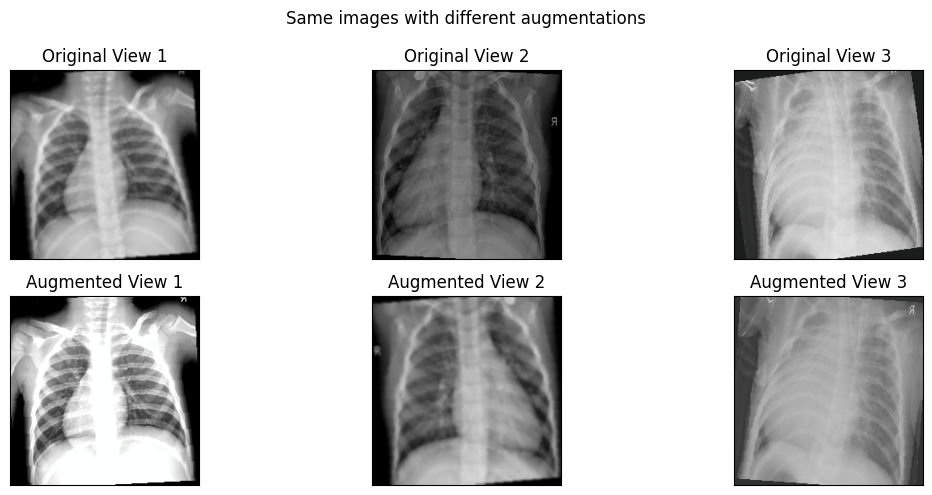

In [8]:
# --- CELL 7: Visualize augmented pairs ---
# Visualize augmented pairs (for verification)
def imshow(img, title=None):
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)

# Get a sample batch and visualize
dataiter = iter(train_loader)
(view1, view2), _ = next(dataiter)

# Plot first few images and their augmented views
fig = plt.figure(figsize=(12, 5))
for i in range(3):  # Show 3 examples
    ax = fig.add_subplot(2, 3, i+1, xticks=[], yticks=[])
    imshow(view1[i], f'Original View {i+1}')
    ax = fig.add_subplot(2, 3, i+4, xticks=[], yticks=[])
    imshow(view2[i], f'Augmented View {i+1}')

plt.suptitle('Same images with different augmentations')
plt.tight_layout()
plt.savefig(save_dir / 'augmented_views.png')
plt.show()

In [9]:
# --- CELL 8: Define model architectures ---
# Define the projection head for SSL
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=512, output_dim=128):
        super().__init__()
        self.projection = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),  # Add batch normalization for better training
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.projection(x)

# Define the overall SSL model
class SSLModel(nn.Module):
    def __init__(self, backbone, projection_dim=128):
        super().__init__()
        self.backbone = backbone
        # Get the output dimension of the backbone
        self.backbone_dim = self.get_backbone_output_dim()
        self.projection = ProjectionHead(
            input_dim=self.backbone_dim,
            hidden_dim=self.backbone_dim,
            output_dim=projection_dim
        )

    def get_backbone_output_dim(self):
        # Check if the backbone is ResNet50
        if isinstance(self.backbone, models.ResNet) and self.backbone.fc.__class__.__name__ != 'Linear':
            return 2048
        if hasattr(self.backbone, 'fc') and isinstance(self.backbone.fc, nn.Linear):
            return self.backbone.fc.in_features
        return 512  # Default fallback

    def forward(self, x):
        features = self.backbone(x)
        # If features is not flattened (still has spatial dimensions)
        if len(features.shape) > 2:
            features = F.adaptive_avg_pool2d(features, (1, 1))
            features = features.view(features.size(0), -1)
        return self.projection(features)

# Define NT-Xent loss for contrastive learning
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.1, epsilon=1e-6):
        super().__init__()
        self.temperature = temperature
        self.epsilon = epsilon

    def forward(self, z_i, z_j):
        batch_size = z_i.shape[0]

        # Normalize embeddings
        z_i = F.normalize(z_i, dim=1)
        z_j = F.normalize(z_j, dim=1)

        # Concatenate representations: [2*B, D]
        representations = torch.cat([z_i, z_j], dim=0)

        # Compute similarity matrix
        similarity_matrix = F.cosine_similarity(
            representations.unsqueeze(1), representations.unsqueeze(0), dim=2
        )

        # Create mask for positive pairs
        mask = torch.zeros_like(similarity_matrix)
        mask[range(batch_size), range(batch_size, 2*batch_size)] = 1.
        mask[range(batch_size, 2*batch_size), range(batch_size)] = 1.

        # Remove self-similarities from the similarity matrix
        diag_mask = ~torch.eye(2*batch_size, dtype=bool, device=z_i.device)
        sim_matrix_masked = similarity_matrix * diag_mask

        # Compute positive similarities (augmented pairs)
        positives = torch.diag(similarity_matrix, batch_size) # similarity between xi and xj
        positives = torch.cat([positives, torch.diag(similarity_matrix, -batch_size)]) # and between xj and xi

        # Compute numerator: exp(sim(z_i, z_j) / temperature)
        numerator = torch.exp(positives / self.temperature)

        # Compute denominator: sum(exp(sim(z_i, z_k) / temperature)) for all k != i
        # First create a mask to zero out self-similarity
        mask = (~torch.eye(2 * batch_size, dtype=bool, device=z_i.device)).float()
        # Compute exp(sim / temperature) with mask
        denominator = torch.exp(similarity_matrix / self.temperature) * mask
        denominator = denominator.sum(dim=1)

        # Compute loss
        loss = -torch.log(numerator / (denominator + self.epsilon))
        loss = loss.mean()

        return loss

# Initialize the backbone for SSL
def init_ssl_model():
    # Load a pre-trained ResNet50 model (more capacity than ResNet18)
    backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    # Replace the final FC layer with Identity to get the feature representations
    backbone.fc = nn.Identity()
    # Create the SSL model
    ssl_model = SSLModel(backbone, projection_dim=128).to(device)
    return ssl_model

In [10]:
# --- CELL 9: Define pneumonia classifier ---
# Create a classifier for downstream task
class PneumoniaClassifier(nn.Module):
    def __init__(self, backbone, num_classes=2):
        super().__init__()
        self.backbone = backbone
        # Freeze the backbone parameters
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Get the output dimension of the backbone
        if hasattr(backbone, 'backbone_dim'):
            self.backbone_dim = backbone.backbone_dim
        else:
            self.backbone_dim = 2048  # For ResNet50

        # Add a more powerful classification head
        self.classifier = nn.Sequential(
            nn.Linear(self.backbone_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # Get features from the backbone (without projection head)
        with torch.no_grad():
            features = self.backbone.backbone(x)
            if len(features.shape) > 2:
                features = F.adaptive_avg_pool2d(features, (1, 1))
                features = features.view(features.size(0), -1)

        # Pass through the classifier
        return self.classifier(features)

In [11]:
# --- CELL 10: Training functions for SSL model ---
# Function to train SSL model for one epoch
def train_ssl_epoch(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    total_loss = 0.0

    for i, ((x_i, x_j), _) in enumerate(train_loader):
        x_i, x_j = x_i.to(device), x_j.to(device)

        # Forward pass for both views
        z_i = model(x_i)
        z_j = model(x_j)

        # Compute contrastive loss
        loss = criterion(z_i, z_j)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Print progress
        if i % 20 == 0:
            print(f"Epoch {epoch+1}, Batch {i}/{len(train_loader)}, Loss: {loss.item():.4f}")

    return total_loss / len(train_loader)

# Function to validate SSL model
def validate_ssl(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for (x_i, x_j), _ in val_loader:
            x_i, x_j = x_i.to(device), x_j.to(device)

            # Forward pass for both views
            z_i = model(x_i)
            z_j = model(x_j)

            # Compute contrastive loss
            loss = criterion(z_i, z_j)
            total_loss += loss.item()

    return total_loss / len(val_loader)

In [14]:
# --- CELL 11: Train the SSL model with Early Stopping ---
ssl_model = init_ssl_model()

num_epochs = 30  # Maximum number of epochs for training
warmup_epochs = 5
patience = 5  # Number of epochs with no improvement to trigger early stopping
best_val_loss = float('inf')
best_epoch = 0  # Tracks the epoch with the best validation loss

optimizer = optim.AdamW(ssl_model.parameters(), lr=3e-4, weight_decay=0.05)
contrastive_criterion = NTXentLoss(temperature=0.07)  # Using a lower temperature for harder negatives

# Define a learning rate scheduler: linear warmup followed by cosine annealing.
def get_lr(epoch):
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    else:
        return 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (num_epochs - warmup_epochs)))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, get_lr)

print("\nTraining SSL model with Early Stopping...")
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Train for one epoch.
    train_loss = train_ssl_epoch(ssl_model, train_loader, contrastive_criterion, optimizer, device, epoch)
    train_losses.append(train_loss)

    # Validate the model.
    val_loss = validate_ssl(ssl_model, val_loader, contrastive_criterion, device)
    val_losses.append(val_loss)

    # Update the learning rate.
    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Check if the validation loss improved.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        torch.save(ssl_model.state_dict(), save_dir / 'best_ssl_model.pth')
        print(f"Saved best model with validation loss: {best_val_loss:.4f}")
    else:
        # If no improvement for 'patience' epochs, trigger early stopping.
        if (epoch - best_epoch) >= patience:
            print(f"Early stopping triggered at epoch {epoch+1} after {patience} epochs with no improvement.")
            break

# Save the final model after training.
torch.save(ssl_model.state_dict(), save_dir / 'final_ssl_model.pth')
print("SSL model training completed and saved!")


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 67.8MB/s]



Training SSL model with Early Stopping...
Epoch 1, Batch 0/28, Loss: 3.9378
Epoch 1, Batch 20/28, Loss: 0.9767
Epoch 1/30, Train Loss: 1.7379, Val Loss: 0.8739, LR: 0.000120
Saved best model with validation loss: 0.8739
Epoch 2, Batch 0/28, Loss: 0.5186
Epoch 2, Batch 20/28, Loss: 0.2262
Epoch 2/30, Train Loss: 0.3033, Val Loss: 0.2109, LR: 0.000180
Saved best model with validation loss: 0.2109
Epoch 3, Batch 0/28, Loss: 0.1077
Epoch 3, Batch 20/28, Loss: 0.0895
Epoch 3/30, Train Loss: 0.0985, Val Loss: 0.1153, LR: 0.000240
Saved best model with validation loss: 0.1153
Epoch 4, Batch 0/28, Loss: 0.0714
Epoch 4, Batch 20/28, Loss: 0.0565
Epoch 4/30, Train Loss: 0.0507, Val Loss: 0.0702, LR: 0.000300
Saved best model with validation loss: 0.0702
Epoch 5, Batch 0/28, Loss: 0.0184
Epoch 5, Batch 20/28, Loss: 0.0262
Epoch 5/30, Train Loss: 0.0339, Val Loss: 0.0543, LR: 0.000300
Saved best model with validation loss: 0.0543
Epoch 6, Batch 0/28, Loss: 0.0309
Epoch 6, Batch 20/28, Loss: 0.038

In [12]:
# --- CELL 12: Load best SSL model and prepare for fine-tuning ---
# Load the best SSL model for downstream task
ssl_model.load_state_dict(torch.load(save_dir / 'best_ssl_model.pth'))
ssl_model.eval()  # Set to evaluation mode

# Create supervised datasets for fine-tuning using the test set
finetune_dataset = ImageFolder(root=ssl_dir / "test", transform=supervised_transform)

# Create a stratified train/val split for more balanced evaluation
from sklearn.model_selection import train_test_split

# Get labels for stratification
labels = [label for _, label in finetune_dataset.samples]

# Create train/val indices with stratification
train_indices, val_indices = train_test_split(
    range(len(finetune_dataset)),
    test_size=0.2,
    stratify=labels,
    random_state=SEED
)

# Create samplers for the dataloaders
from torch.utils.data import SubsetRandomSampler

# Create data loaders with the sampled indices
finetune_train_loader = DataLoader(
    finetune_dataset,
    batch_size=64,
    sampler=SubsetRandomSampler(train_indices),
    num_workers=2,
    pin_memory=True
)

finetune_val_loader = DataLoader(
    finetune_dataset,
    batch_size=64,
    sampler=SubsetRandomSampler(val_indices),
    num_workers=2,
    pin_memory=True
)

# Test dataset with clean transformations
test_clean_dataset = ImageFolder(root=ssl_dir / "test", transform=test_transform)
test_clean_loader = DataLoader(test_clean_dataset, batch_size=64, shuffle=False, num_workers=2)

NameError: name 'ssl_model' is not defined

In [16]:
# --- CELL 13: Initialize and fine-tune the classifier ---
# Initialize the classifier using the pretrained SSL backbone
pneumonia_classifier = PneumoniaClassifier(ssl_model, num_classes=2).to(device)

# Define loss function and optimizer for classifier
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0]).to(device))  # Weight pneumonia class higher
classifier_optimizer = optim.AdamW(pneumonia_classifier.classifier.parameters(),
                                  lr=1e-3, weight_decay=0.01)

# Learning rate scheduler
classifier_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    classifier_optimizer, mode='max', factor=0.1, patience=3, verbose=True
)

# Function to train the classifier
def train_classifier_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track accuracy
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        total_loss += loss.item()

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(train_loader)
    return avg_loss, accuracy

# Function to validate the classifier
def validate_classifier(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Calculate probabilities
            probs = F.softmax(outputs, dim=1)

            # Track accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            total_loss += loss.item()

            # Save probabilities and labels for AUC calculation
            all_probs.extend(probs[:, 1].cpu().numpy())  # Pneumonia class probability
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(val_loader)

    # Calculate AUC
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    return avg_loss, accuracy, roc_auc

# Fine-tune the classifier
num_finetune_epochs = 20
print("\nFine-tuning the classifier...")
finetune_losses = []
finetune_accs = []
val_losses = []
val_accs = []
val_aucs = []
best_val_acc = 0.0

for epoch in range(num_finetune_epochs):
    # Train
    loss, accuracy = train_classifier_epoch(
        pneumonia_classifier, finetune_train_loader, criterion, classifier_optimizer, device
    )
    finetune_losses.append(loss)
    finetune_accs.append(accuracy)

    # Validate
    val_loss, val_accuracy, val_auc = validate_classifier(
        pneumonia_classifier, finetune_val_loader, criterion, device
    )
    val_losses.append(val_loss)
    val_accs.append(val_accuracy)
    val_aucs.append(val_auc)

    # Update learning rate based on validation accuracy
    classifier_scheduler.step(val_accuracy)

    # Print progress
    print(f"Epoch {epoch+1}/{num_finetune_epochs}, Train Loss: {loss:.4f}, Train Acc: {accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%, Val AUC: {val_auc:.4f}")

    # Save best model
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(pneumonia_classifier.state_dict(), save_dir / 'best_pneumonia_classifier.pth')
        print(f"Saved best model with validation accuracy: {best_val_acc:.2f}%")

# Save the final classifier
torch.save(pneumonia_classifier.state_dict(), save_dir / 'final_pneumonia_classifier.pth')
print("Classifier fine-tuning completed!")


Fine-tuning the classifier...
Epoch 1/20, Train Loss: 0.4171, Train Acc: 81.36%, Val Loss: 0.3580, Val Acc: 88.00%, Val AUC: 0.9509
Saved best model with validation accuracy: 88.00%
Epoch 2/20, Train Loss: 0.2047, Train Acc: 90.18%, Val Loss: 0.2163, Val Acc: 89.60%, Val AUC: 0.9724
Saved best model with validation accuracy: 89.60%
Epoch 3/20, Train Loss: 0.1500, Train Acc: 92.59%, Val Loss: 0.2226, Val Acc: 90.40%, Val AUC: 0.9722
Saved best model with validation accuracy: 90.40%
Epoch 4/20, Train Loss: 0.1656, Train Acc: 92.59%, Val Loss: 0.2503, Val Acc: 91.20%, Val AUC: 0.9744
Saved best model with validation accuracy: 91.20%
Epoch 5/20, Train Loss: 0.1294, Train Acc: 93.79%, Val Loss: 0.2080, Val Acc: 92.00%, Val AUC: 0.9804
Saved best model with validation accuracy: 92.00%
Epoch 6/20, Train Loss: 0.1300, Train Acc: 93.19%, Val Loss: 0.1896, Val Acc: 92.80%, Val AUC: 0.9853
Saved best model with validation accuracy: 92.80%
Epoch 7/20, Train Loss: 0.1027, Train Acc: 95.19%, Val Lo

NameError: name 'num_finetune_epochs' is not defined

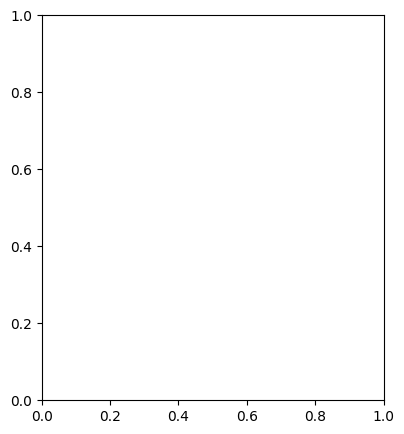

In [16]:
# --- CELL 14: Plot training metrics ---
# Plot the fine-tuning loss and accuracy
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, num_finetune_epochs+1), finetune_losses, label='Train Loss')
plt.plot(range(1, num_finetune_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Classifier Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(range(1, num_finetune_epochs+1), finetune_accs, label='Train Accuracy')
plt.plot(range(1, num_finetune_epochs+1), val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Classifier Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(range(1, num_finetune_epochs+1), val_aucs)
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation AUC')
plt.grid(True)

plt.tight_layout()
plt.savefig(save_dir / 'finetune_metrics.png')
plt.show()

In [13]:
ssl_model = init_ssl_model()  # Initialize the model architecture
ssl_model.load_state_dict(torch.load(save_dir / 'best_ssl_model.pth'))
ssl_model.eval()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 36.1MB/s]


SSLModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [15]:
# Load the pneumonia classifier model
pneumonia_classifier = PneumoniaClassifier(ssl_model, num_classes=2).to(device)
pneumonia_classifier.load_state_dict(torch.load(save_dir / 'final_pneumonia_classifier.pth'))
pneumonia_classifier.to(device)
pneumonia_classifier.eval()


PneumoniaClassifier(
  (backbone): SSLModel(
    (backbone): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu)

In [17]:
# --- CELL 15: Interactive Test Explorer ---
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Assuming 'test_dataset' is your ImageFolder test dataset and
# 'pneumonia_classifier' is your fine-tuned classifier model on the device.
# Also, test_transform is already defined.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Extract test file paths and true labels from the ImageFolder dataset.
test_files = [str(path) for path, _ in test_dataset.samples]
true_labels = [label for _, label in test_dataset.samples]
class_names = test_dataset.classes

# Create ipywidgets: Dropdown for selecting a sample and slider for confidence threshold.
test_sample_selector = widgets.Dropdown(
    options=[(f"Sample {i}", i) for i in range(len(test_files))],
    description='Select Sample:',
    style={'description_width': 'initial'}
)

confidence_threshold = widgets.FloatSlider(
    value=0.7,
    min=0,
    max=1.0,
    step=0.05,
    description='Confidence Threshold:',
    style={'description_width': 'initial'}
)

prediction_output = widgets.Output()

def update_test_sample(change):
    with prediction_output:
        prediction_output.clear_output(wait=True)
        idx = test_sample_selector.value
        img_path = test_files[idx]
        true_class = class_names[true_labels[idx]]

        # Load and preprocess image using PIL and test_transform.
        image = Image.open(img_path).convert("RGB")
        plt.figure(figsize=(8, 6))
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"True Label: {true_class}")
        plt.show()

        # Preprocess image: apply test_transform and add batch dimension.
        img_tensor = test_transform(image).unsqueeze(0).to(device)

        # Make prediction with the classifier.
        pneumonia_classifier.eval()
        with torch.no_grad():
            outputs = pneumonia_classifier(img_tensor)
            probs = torch.softmax(outputs, dim=1)[0].cpu().numpy()

        pred_idx = np.argmax(probs)
        pred_class = class_names[pred_idx]
        confidence = np.max(probs)

        # Display prediction results.
        print(f"Predicted: {pred_class} ({confidence*100:.1f}% confidence)")

        # Bar plot of confidence distribution for all classes.
        plt.figure(figsize=(10, 3))
        sorted_indices = np.argsort(probs)[::-1]
        bar_colors = ['green' if probs[i] >= confidence_threshold.value else 'gray' for i in sorted_indices]
        plt.bar(range(len(probs)), probs[sorted_indices], color=bar_colors)
        plt.xticks(range(len(probs)), [class_names[i] for i in sorted_indices], rotation=45)
        plt.ylabel("Confidence")
        plt.axhline(confidence_threshold.value, color='red', linestyle='--', label='Threshold')
        plt.legend()
        plt.title("Model Confidence Across Classes")
        plt.show()

# Link widget changes to the update function.
test_sample_selector.observe(update_test_sample, names='value')
confidence_threshold.observe(update_test_sample, names='value')

# Display the interactive interface.
print("\n🔍 Interactive Test Explorer")
display(widgets.VBox([test_sample_selector, confidence_threshold]))
display(prediction_output)

# Trigger the initial update.
update_test_sample(None)



🔍 Interactive Test Explorer


Output()